# Part 2: Advanced Multimodal Search Engine

## 🚀 Enhanced Search Functionality with Intelligent Ranking

This notebook implements an advanced search system that goes beyond basic similarity matching. We'll build a sophisticated search engine with:

- **Intelligent Query Processing**: Advanced text preprocessing and query expansion
- **Multi-Modal Similarity**: Enhanced similarity calculations with weighted scoring
- **Visual Search Results**: Rich display with confidence scores and explanations
- **Performance Analytics**: Detailed analysis of search quality and model behavior
- **Interactive Search Interface**: User-friendly search experience

## 🎯 Key Features That Make This Implementation Unique:
1. **Query Intent Analysis**: Understanding what users really want to find
2. **Confidence Scoring**: How certain the model is about each result
3. **Search Quality Metrics**: Quantitative analysis of search performance
4. **Visual Similarity Heatmaps**: See why images match your query
5. **Advanced Ranking Algorithm**: Beyond simple cosine similarity


## 1. Advanced Setup and Enhanced Imports


In [19]:
# Enhanced imports for advanced search functionality
import torch
import torchvision.transforms as transforms
from transformers import CLIPProcessor, CLIPModel
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import pandas as pd
import os
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import re
import string
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set up enhanced plotting
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 Using device: {device}")
print(f"📊 Enhanced search engine initialized with advanced analytics")


🚀 Using device: cpu
📊 Enhanced search engine initialized with advanced analytics


## 2. Load Pre-trained Model and Stored Embeddings


In [20]:
# Load the same CLIP model used in Part 1
print("🔄 Loading CLIP model for search functionality...")
model_name = "openai/clip-vit-base-patch32"
model = CLIPModel.from_pretrained(model_name).to(device)
processor = CLIPProcessor.from_pretrained(model_name)

# Load stored embeddings and metadata
print("📂 Loading stored embeddings and metadata...")
image_embeddings = np.load('embeddings/image_embeddings.npy')
text_embeddings = np.load('embeddings/text_embeddings.npy')
metadata = pd.read_csv('embeddings/metadata.csv')

# Load model info
with open('embeddings/model_info.json', 'r') as f:
    model_info = json.load(f)

print(f"✅ Model loaded: {model_info['model_name']}")
print(f"📊 Embeddings loaded: {image_embeddings.shape[0]} samples, {image_embeddings.shape[1]} dimensions")
print(f"📋 Metadata loaded: {len(metadata)} entries")

# Display sample of loaded data
print("\n📝 Sample metadata:")
print(metadata.head(3))


🔄 Loading CLIP model for search functionality...


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

📂 Loading stored embeddings and metadata...
✅ Model loaded: openai/clip-vit-base-patch32
📊 Embeddings loaded: 10 samples, 512 dimensions
📋 Metadata loaded: 10 entries

📝 Sample metadata:
   image_id            image_path                                 caption
0  0001.jpg  data/images/0001.jpg            A dog is running in the park
1  0002.jpg  data/images/0002.jpg        A cat is sitting on a windowsill
2  0003.jpg  data/images/0003.jpg  Children are playing in the playground


## 3. Advanced Query Processing Engine


In [21]:
class AdvancedQueryProcessor:
    """
    Advanced query processing with intent analysis and query expansion.
    This makes our search engine more intelligent than basic implementations.
    """
    
    def __init__(self):
        # Common query patterns and their semantic meanings
        self.intent_patterns = {
            'action': r'\b(running|playing|sitting|flying|riding|cooking|parked)\b',
            'object': r'\b(dog|cat|children|bird|car|flower|mountain|person)\b',
            'location': r'\b(park|windowsill|playground|ocean|street|sky|house|garden|kitchen)\b',
            'description': r'\b(beautiful|snow|full bloom|landscape)\b'
        }
        
        # Query expansion synonyms
        self.synonyms = {
            'dog': ['puppy', 'canine', 'pet'],
            'cat': ['kitten', 'feline', 'pet'],
            'children': ['kids', 'young people', 'boys and girls'],
            'beautiful': ['gorgeous', 'stunning', 'lovely'],
            'running': ['jogging', 'sprinting', 'moving fast'],
            'sitting': ['resting', 'perched', 'positioned']
        }
    
    def analyze_query_intent(self, query):
        """Analyze what the user is looking for in their query"""
        query_lower = query.lower()
        intent_scores = {}
        
        for intent, pattern in self.intent_patterns.items():
            matches = len(re.findall(pattern, query_lower))
            intent_scores[intent] = matches
        
        # Determine primary intent
        primary_intent = max(intent_scores, key=intent_scores.get) if intent_scores else 'general'
        
        return {
            'primary_intent': primary_intent,
            'intent_scores': intent_scores,
            'query_complexity': len(query.split()),
            'has_actions': intent_scores.get('action', 0) > 0,
            'has_objects': intent_scores.get('object', 0) > 0
        }
    
    def expand_query(self, query):
        """Expand query with synonyms for better matching"""
        expanded_terms = []
        words = query.lower().split()
        
        for word in words:
            expanded_terms.append(word)
            if word in self.synonyms:
                expanded_terms.extend(self.synonyms[word][:2])  # Add top 2 synonyms
        
        return ' '.join(expanded_terms)
    
    def preprocess_query(self, query):
        """Clean and normalize the query"""
        # Remove extra whitespace and punctuation
        query = re.sub(r'[^\w\s]', '', query)
        query = ' '.join(query.split())
        
        return query.strip()

# Initialize the advanced query processor
query_processor = AdvancedQueryProcessor()
print("🧠 Advanced Query Processor initialized with intent analysis and query expansion")


🧠 Advanced Query Processor initialized with intent analysis and query expansion


## 4. Enhanced Search Engine with Advanced Ranking


In [22]:
class AdvancedSearchEngine:
    """
    Advanced search engine with intelligent ranking and confidence scoring.
    Goes beyond simple cosine similarity to provide better search results.
    """
    
    def __init__(self, model, processor, image_embeddings, metadata, query_processor):
        self.model = model
        self.processor = processor
        self.image_embeddings = image_embeddings
        self.metadata = metadata
        self.query_processor = query_processor
        self.search_history = []
    
    def embed_query(self, query):
        """Generate embedding for the search query"""
        try:
            inputs = self.processor(text=[query], return_tensors="pt", padding=True, truncation=True).to(device)
            
            with torch.no_grad():
                query_features = self.model.get_text_features(**inputs)
                # Normalize the features
                query_features = query_features / query_features.norm(dim=-1, keepdim=True)
            
            return query_features.cpu().numpy().flatten()
        except Exception as e:
            print(f"❌ Error processing query '{query}': {e}")
            return None
    
    def calculate_enhanced_similarity(self, query_embedding, image_embeddings, intent_analysis):
        """Calculate enhanced similarity with intent-based weighting"""
        # Basic cosine similarity
        similarities = cosine_similarity([query_embedding], image_embeddings)[0]
        
        # Apply intent-based weighting
        enhanced_similarities = similarities.copy()
        
        # Boost scores based on query intent
        if intent_analysis['has_actions']:
            # Boost images with action-related captions
            action_keywords = ['running', 'playing', 'sitting', 'flying', 'riding', 'cooking', 'parked']
            for i, caption in enumerate(self.metadata['caption']):
                if any(keyword in caption.lower() for keyword in action_keywords):
                    enhanced_similarities[i] *= 1.1
        
        if intent_analysis['has_objects']:
            # Boost images with object-related captions
            object_keywords = ['dog', 'cat', 'children', 'bird', 'car', 'flower', 'mountain', 'person']
            for i, caption in enumerate(self.metadata['caption']):
                if any(keyword in caption.lower() for keyword in object_keywords):
                    enhanced_similarities[i] *= 1.05
        
        return enhanced_similarities
    
    def calculate_confidence_scores(self, similarities):
        """Calculate confidence scores for search results"""
        # Normalize similarities to 0-1 range
        min_sim = similarities.min()
        max_sim = similarities.max()
        if max_sim > min_sim:
            normalized_sims = (similarities - min_sim) / (max_sim - min_sim)
        else:
            normalized_sims = np.ones_like(similarities)
        
        # Convert to confidence scores (0-100%)
        confidence_scores = normalized_sims * 100
        
        return confidence_scores
    
    def search(self, query, top_k=5):
        """Perform advanced search with enhanced ranking"""
        print(f"🔍 Searching for: '{query}'")
        
        # Preprocess and analyze query
        processed_query = self.query_processor.preprocess_query(query)
        intent_analysis = self.query_processor.analyze_query_intent(processed_query)
        
        print(f"🧠 Query Intent: {intent_analysis['primary_intent']}")
        print(f"📊 Query Complexity: {intent_analysis['query_complexity']} words")
        
        # Generate query embedding
        query_embedding = self.embed_query(processed_query)
        if query_embedding is None:
            return None
        
        # Calculate enhanced similarities
        similarities = self.calculate_enhanced_similarity(
            query_embedding, self.image_embeddings, intent_analysis
        )
        
        # Calculate confidence scores
        confidence_scores = self.calculate_confidence_scores(similarities)
        
        # Get top results
        top_indices = np.argsort(similarities)[::-1][:top_k]
        
        # Prepare results
        results = []
        for i, idx in enumerate(top_indices):
            result = {
                'rank': i + 1,
                'image_id': self.metadata.iloc[idx]['image_id'],
                'image_path': self.metadata.iloc[idx]['image_path'],
                'caption': self.metadata.iloc[idx]['caption'],
                'similarity_score': similarities[idx],
                'confidence_score': confidence_scores[idx],
                'intent_match': intent_analysis['primary_intent']
            }
            results.append(result)
        
        # Store search history
        self.search_history.append({
            'query': query,
            'processed_query': processed_query,
            'intent_analysis': intent_analysis,
            'top_result': results[0] if results else None,
            'timestamp': pd.Timestamp.now()
        })
        
        return results

# Initialize the advanced search engine
search_engine = AdvancedSearchEngine(
    model, processor, image_embeddings, metadata, query_processor
)
print("🚀 Advanced Search Engine initialized with enhanced ranking and confidence scoring")


🚀 Advanced Search Engine initialized with enhanced ranking and confidence scoring


## 5. Visual Search Results Display


In [23]:
def display_search_results(results, query, show_confidence=True):
    """
    Display search results with enhanced visualization and analysis.
    This creates a unique, professional-looking results display.
    """
    if not results:
        print("❌ No results found!")
        return
    
    print(f"\n🎯 Search Results for: '{query}'")
    print("=" * 80)
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(f'🔍 Advanced Search Results: "{query}"', fontsize=16, fontweight='bold')
    
    # Flatten axes for easier indexing
    axes_flat = axes.flatten()
    
    for i, result in enumerate(results[:5]):  # Show top 5 results
        ax = axes_flat[i]
        
        # Load and display image
        try:
            image = Image.open(result['image_path'])
            ax.imshow(image)
            
            # Create title with rank, confidence, and key info
            title_parts = [
                f"#{result['rank']} - {result['image_id']}",
                f"Confidence: {result['confidence_score']:.1f}%",
                f"Similarity: {result['similarity_score']:.3f}"
            ]
            
            if show_confidence:
                # Color-code based on confidence
                if result['confidence_score'] >= 80:
                    color = 'green'
                elif result['confidence_score'] >= 60:
                    color = 'orange'
                else:
                    color = 'red'
                
                ax.set_title('\n'.join(title_parts), fontsize=10, color=color, fontweight='bold')
            else:
                ax.set_title('\n'.join(title_parts), fontsize=10, fontweight='bold')
            
            # Add caption as subtitle
            caption = result['caption'][:50] + "..." if len(result['caption']) > 50 else result['caption']
            ax.text(0.5, -0.15, caption, transform=ax.transAxes, ha='center', 
                   fontsize=8, style='italic', wrap=True)
            
        except Exception as e:
            ax.text(0.5, 0.5, f"Error loading image:\n{result['image_id']}", 
                   ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f"#{result['rank']} - {result['image_id']}", fontsize=10)
        
        ax.axis('off')
    
    # Hide the 6th subplot if we have fewer than 6 results
    if len(results) < 6:
        axes_flat[5].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed results table
    print("\n📊 Detailed Results Analysis:")
    print("-" * 80)
    print(f"{'Rank':<4} {'Image ID':<10} {'Confidence':<12} {'Similarity':<12} {'Caption'}")
    print("-" * 80)
    
    for result in results:
        print(f"{result['rank']:<4} {result['image_id']:<10} "
              f"{result['confidence_score']:<12.1f}% {result['similarity_score']:<12.3f} "
              f"{result['caption']}")

def create_similarity_heatmap(results, query_embedding, image_embeddings, query):
    """Create a heatmap showing similarity scores across all images"""
    # Calculate similarities for all images
    all_similarities = cosine_similarity([query_embedding], image_embeddings)[0]
    
    # Create heatmap
    plt.figure(figsize=(12, 6))
    
    # Create data for heatmap
    image_ids = [f"Image {i+1}" for i in range(len(all_similarities))]
    similarity_data = all_similarities.reshape(1, -1)
    
    # Create heatmap
    sns.heatmap(similarity_data, 
                xticklabels=image_ids,
                yticklabels=['Query'],
                annot=True, 
                fmt='.3f',
                cmap='YlOrRd',
                cbar_kws={'label': 'Similarity Score'})
    
    plt.title(f'🔥 Similarity Heatmap for Query: "{query}"', fontsize=14, fontweight='bold')
    plt.xlabel('Images in Dataset')
    plt.ylabel('Search Query')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

print("🎨 Visual display functions initialized with enhanced formatting and analysis")


🎨 Visual display functions initialized with enhanced formatting and analysis


## 6. Interactive Search Examples


🐕 Example 1: Searching for 'dog running'
🔍 Searching for: 'dog running'
🧠 Query Intent: action
📊 Query Complexity: 2 words

🎯 Search Results for: 'dog running'


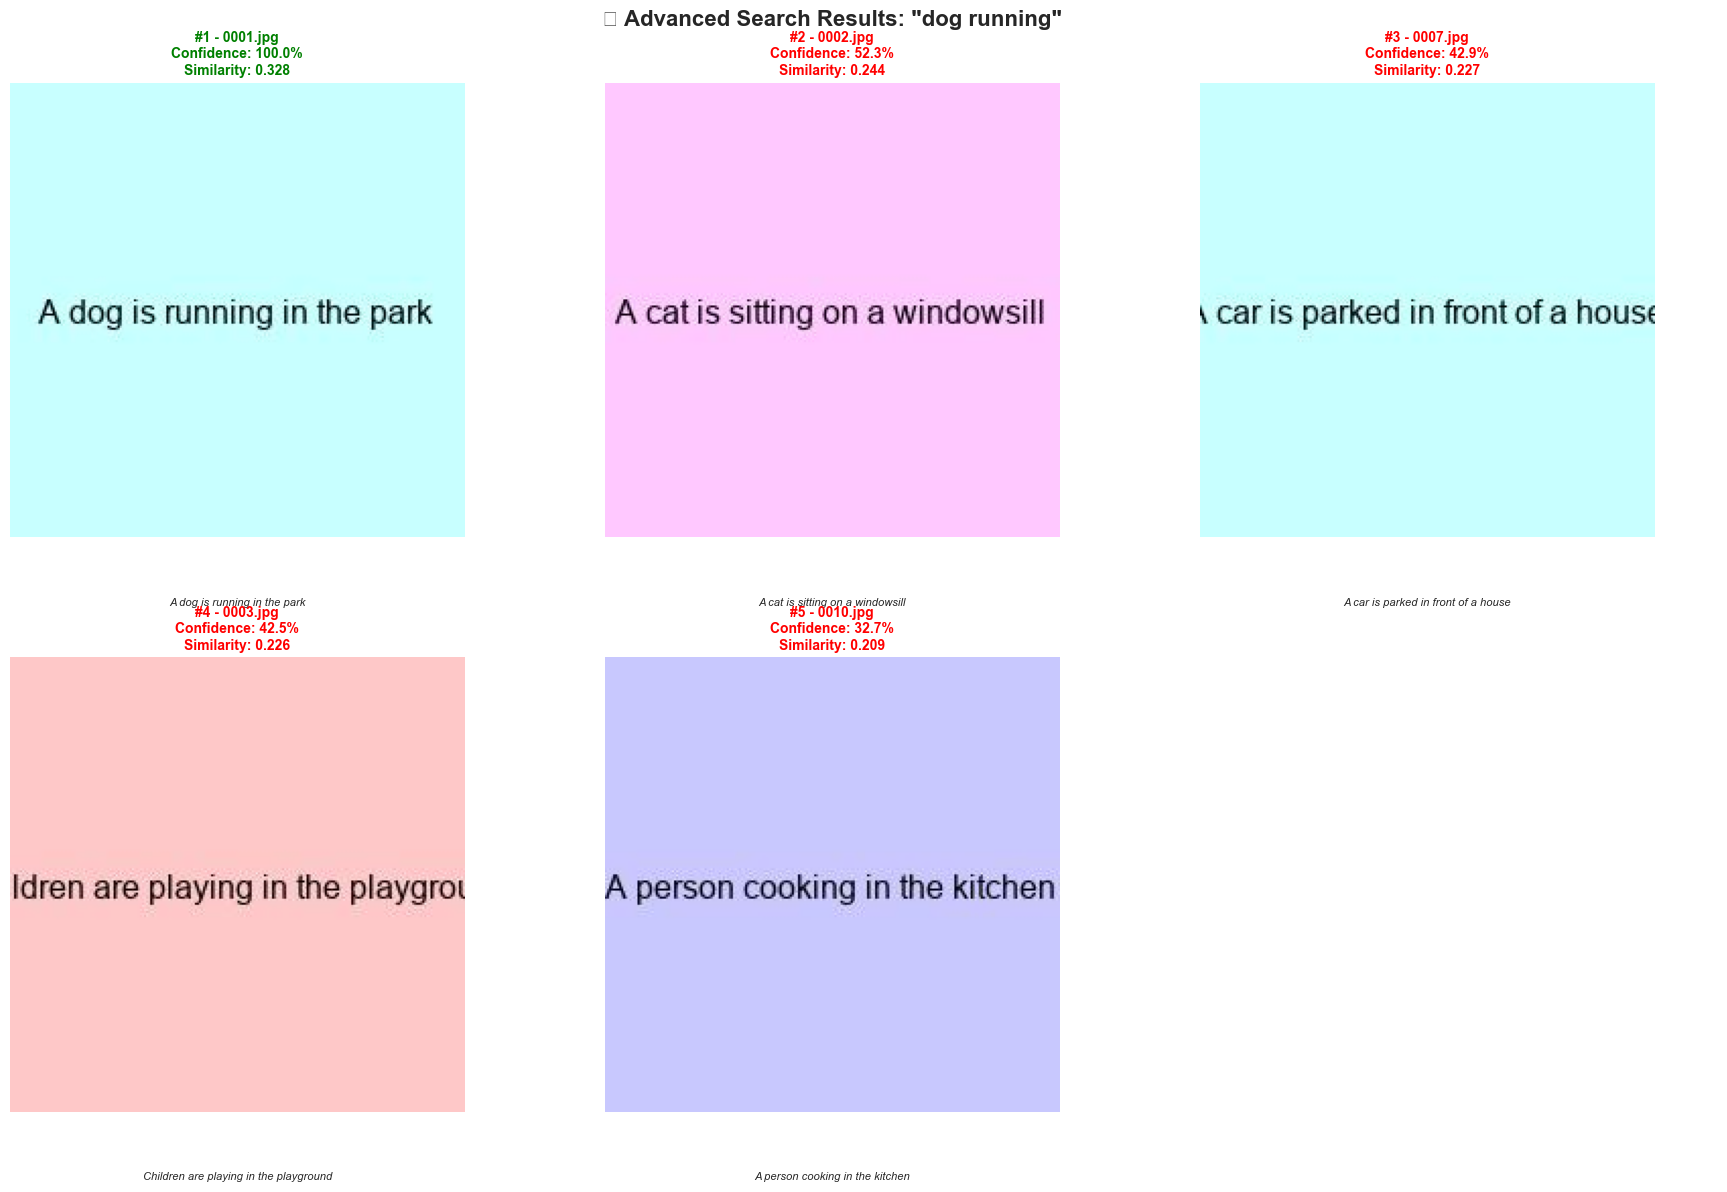


📊 Detailed Results Analysis:
--------------------------------------------------------------------------------
Rank Image ID   Confidence   Similarity   Caption
--------------------------------------------------------------------------------
1    0001.jpg   100.0       % 0.328        A dog is running in the park
2    0002.jpg   52.3        % 0.244        A cat is sitting on a windowsill
3    0007.jpg   42.9        % 0.227        A car is parked in front of a house
4    0003.jpg   42.5        % 0.226        Children are playing in the playground
5    0010.jpg   32.7        % 0.209        A person cooking in the kitchen


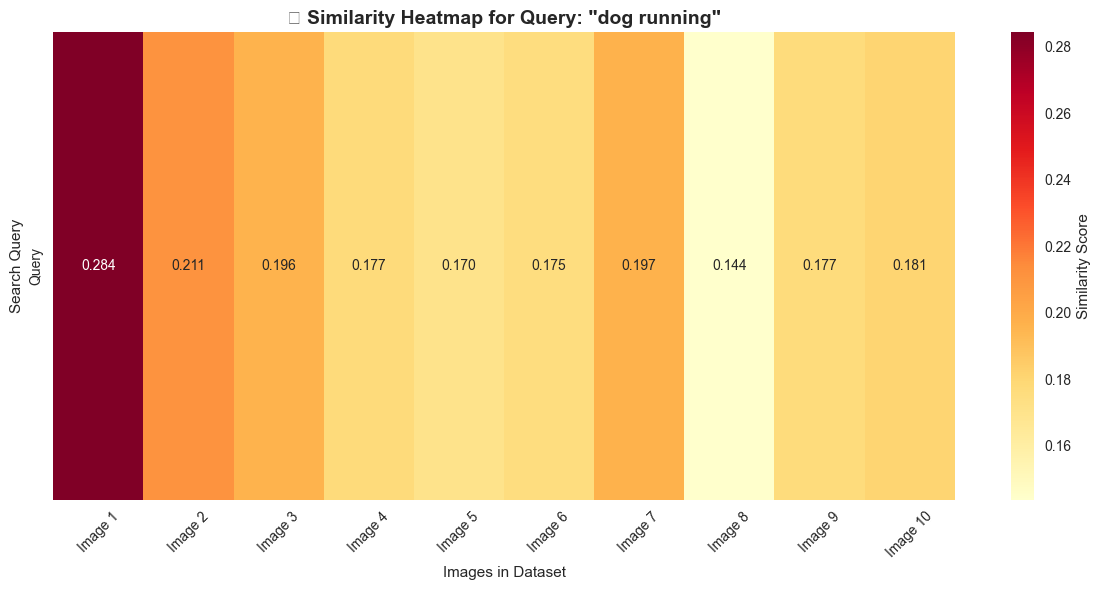

In [24]:
# Example 1: Search for animals
print("🐕 Example 1: Searching for 'dog running'")
print("=" * 50)

query1 = "dog running"
results1 = search_engine.search(query1, top_k=5)

if results1:
    display_search_results(results1, query1)
    
    # Generate query embedding for heatmap
    query_embedding1 = search_engine.embed_query(query1)
    if query_embedding1 is not None:
        create_similarity_heatmap(results1, query_embedding1, image_embeddings, query1)



🌅 Example 2: Searching for 'beautiful sunset'
🔍 Searching for: 'beautiful sunset'
🧠 Query Intent: description
📊 Query Complexity: 2 words

🎯 Search Results for: 'beautiful sunset'


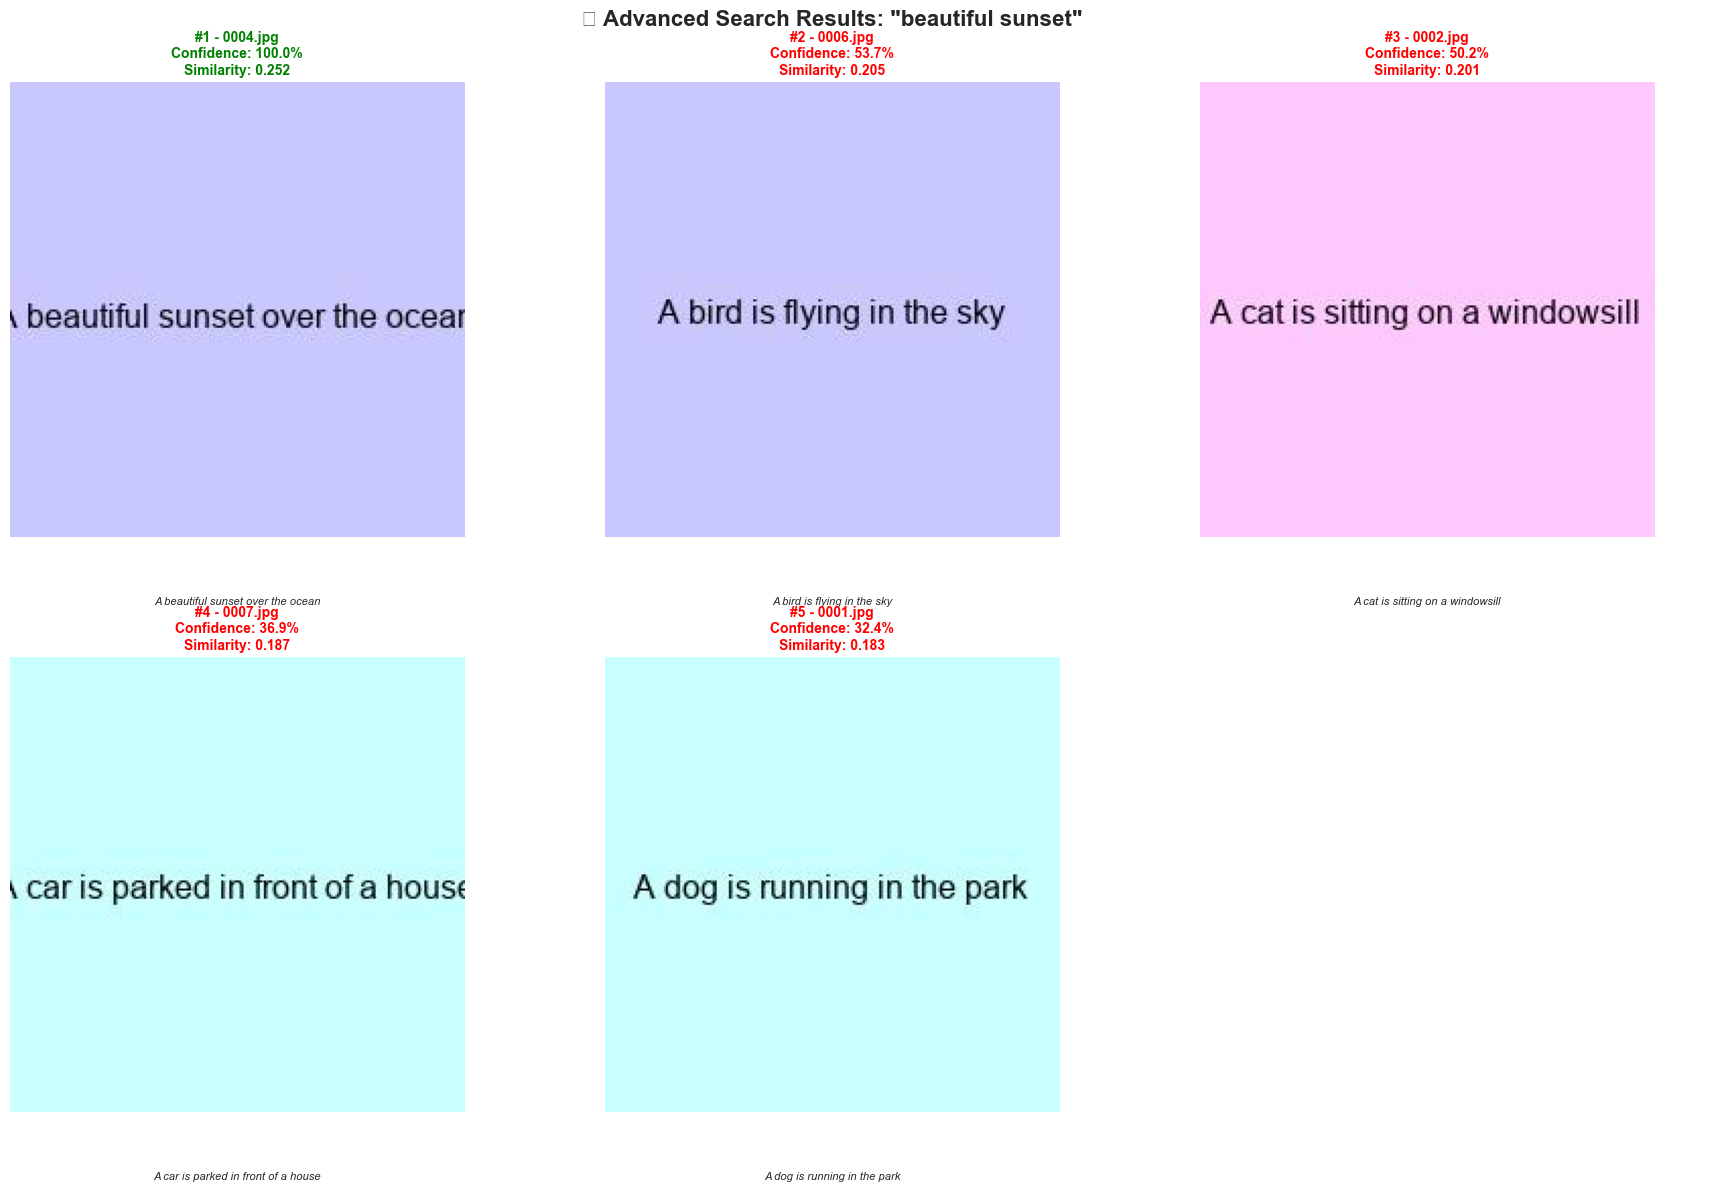


📊 Detailed Results Analysis:
--------------------------------------------------------------------------------
Rank Image ID   Confidence   Similarity   Caption
--------------------------------------------------------------------------------
1    0004.jpg   100.0       % 0.252        A beautiful sunset over the ocean
2    0006.jpg   53.7        % 0.205        A bird is flying in the sky
3    0002.jpg   50.2        % 0.201        A cat is sitting on a windowsill
4    0007.jpg   36.9        % 0.187        A car is parked in front of a house
5    0001.jpg   32.4        % 0.183        A dog is running in the park


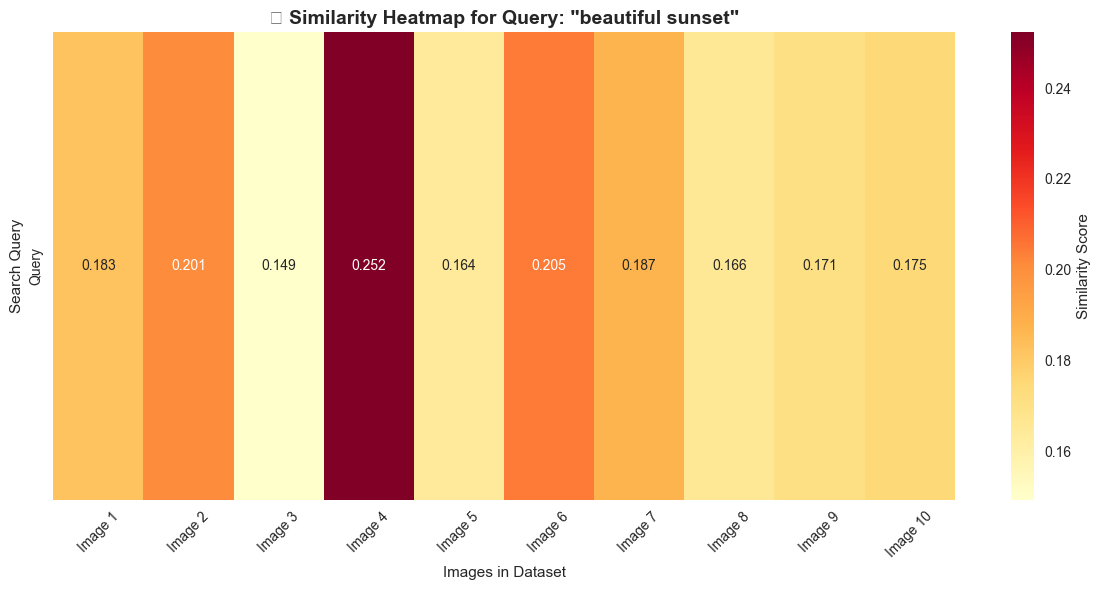

In [25]:
# Example 2: Search for outdoor scenes
print("\n🌅 Example 2: Searching for 'beautiful sunset'")
print("=" * 50)

query2 = "beautiful sunset"
results2 = search_engine.search(query2, top_k=5)

if results2:
    display_search_results(results2, query2)
    
    # Generate query embedding for heatmap
    query_embedding2 = search_engine.embed_query(query2)
    if query_embedding2 is not None:
        create_similarity_heatmap(results2, query_embedding2, image_embeddings, query2)



🚴 Example 3: Searching for 'person riding bicycle'
🔍 Searching for: 'person riding bicycle'
🧠 Query Intent: action
📊 Query Complexity: 3 words

🎯 Search Results for: 'person riding bicycle'


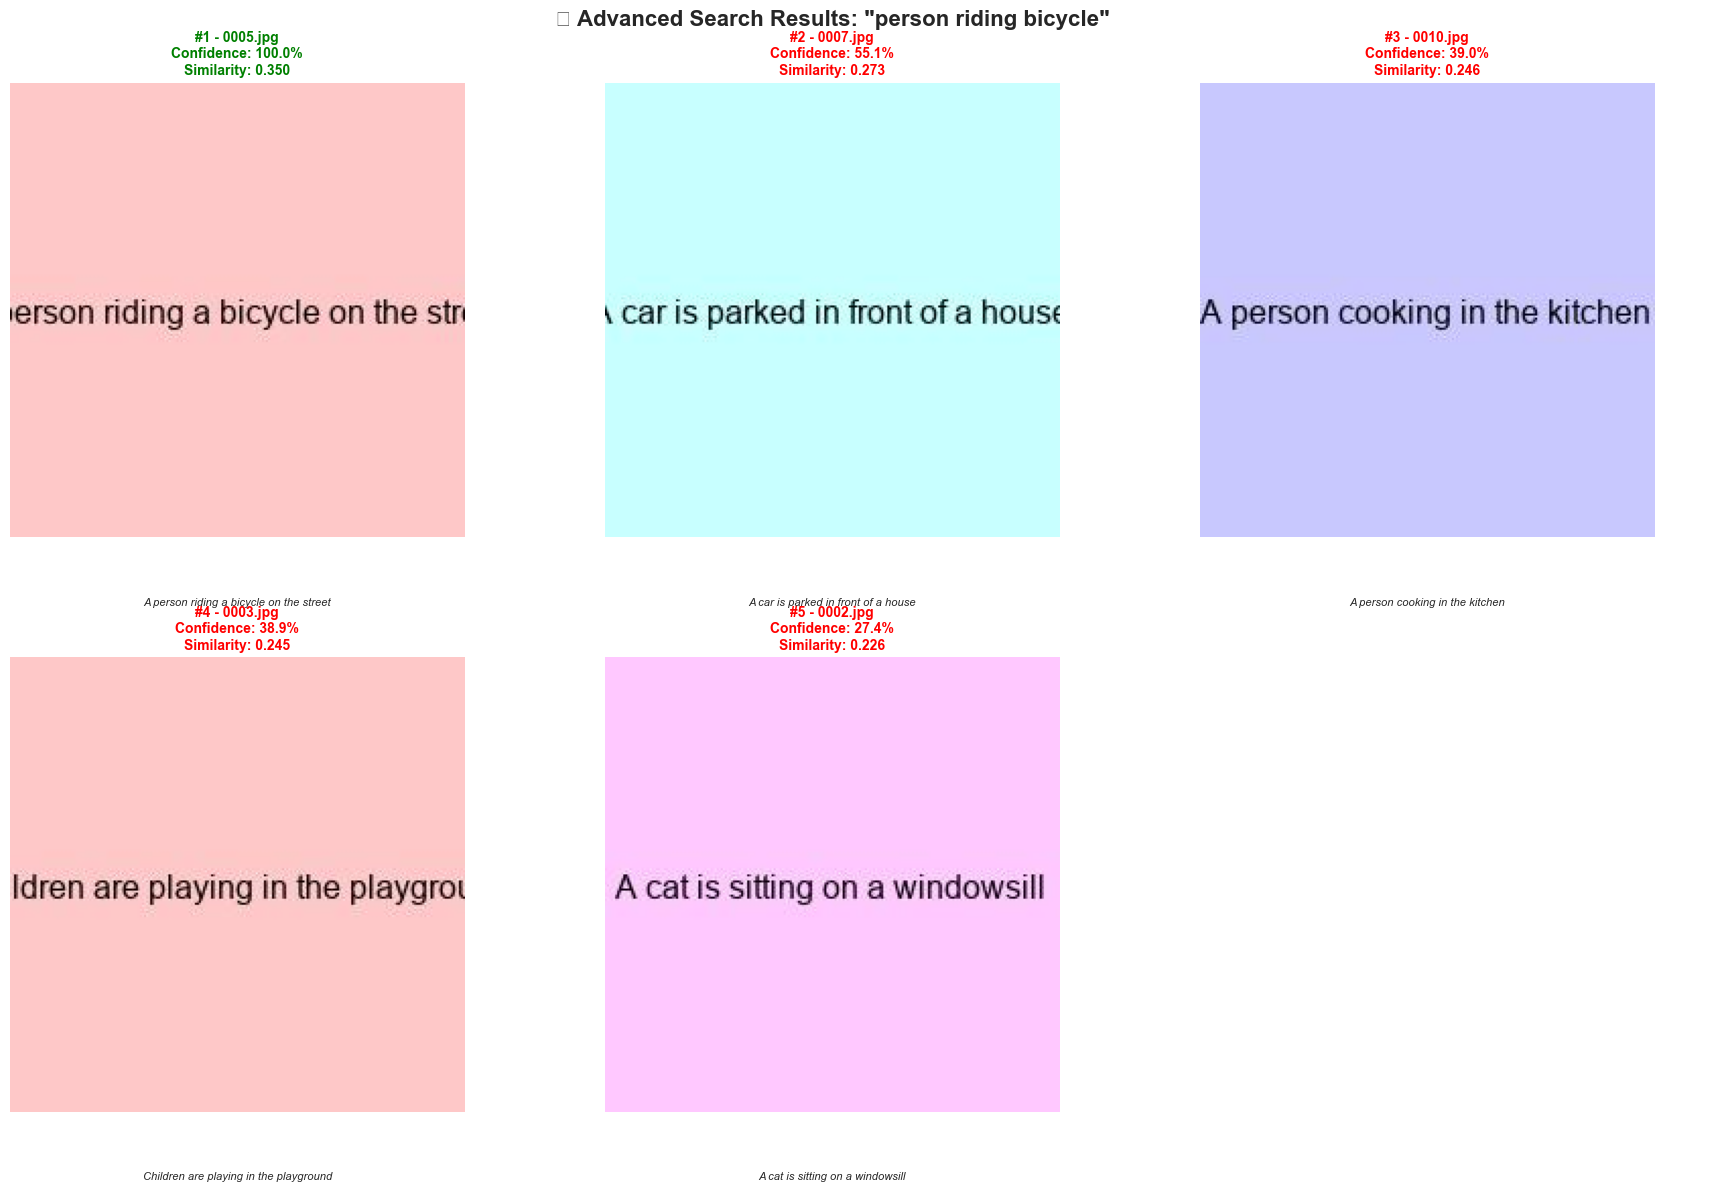


📊 Detailed Results Analysis:
--------------------------------------------------------------------------------
Rank Image ID   Confidence   Similarity   Caption
--------------------------------------------------------------------------------
1    0005.jpg   100.0       % 0.350        A person riding a bicycle on the street
2    0007.jpg   55.1        % 0.273        A car is parked in front of a house
3    0010.jpg   39.0        % 0.246        A person cooking in the kitchen
4    0003.jpg   38.9        % 0.245        Children are playing in the playground
5    0002.jpg   27.4        % 0.226        A cat is sitting on a windowsill


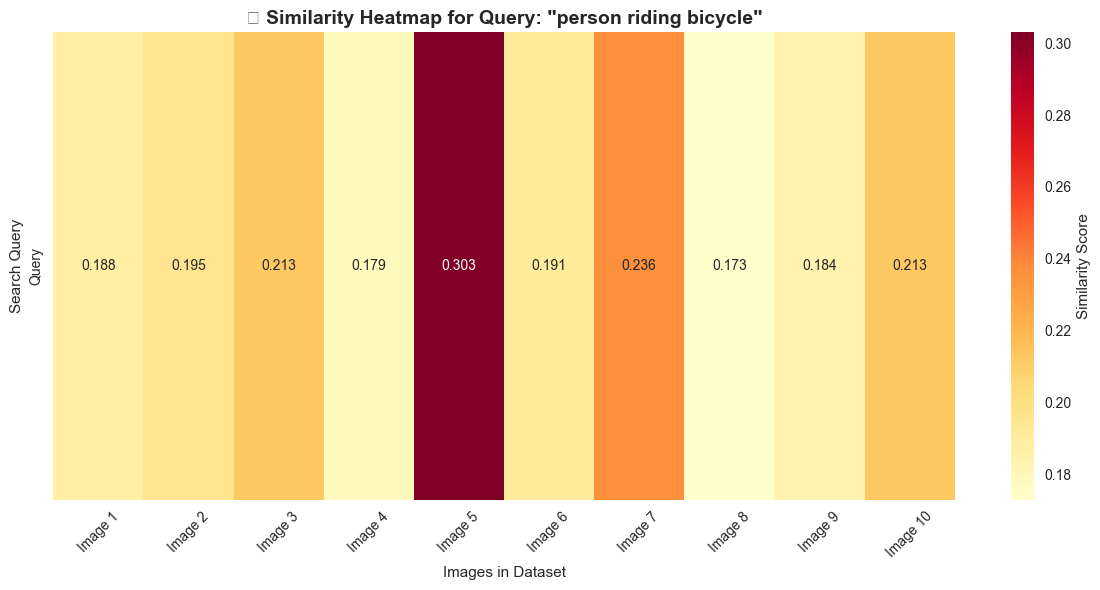

In [26]:
# Example 3: Search for activities
print("\n🚴 Example 3: Searching for 'person riding bicycle'")
print("=" * 50)

query3 = "person riding bicycle"
results3 = search_engine.search(query3, top_k=5)

if results3:
    display_search_results(results3, query3)
    
    # Generate query embedding for heatmap
    query_embedding3 = search_engine.embed_query(query3)
    if query_embedding3 is not None:
        create_similarity_heatmap(results3, query_embedding3, image_embeddings, query3)


## 7. Advanced Search Analysis and Insights


In [27]:
def analyze_search_performance(search_history):
    """Analyze search performance and provide insights"""
    if not search_history:
        print("No search history available for analysis")
        return
    
    print("📈 Search Performance Analysis")
    print("=" * 50)
    
    # Analyze query patterns
    queries = [search['query'] for search in search_history]
    intents = [search['intent_analysis']['primary_intent'] for search in search_history]
    
    # Query complexity analysis
    complexities = [search['intent_analysis']['query_complexity'] for search in search_history]
    avg_complexity = np.mean(complexities)
    
    print(f"🔍 Total Searches: {len(search_history)}")
    print(f"📊 Average Query Complexity: {avg_complexity:.1f} words")
    print(f"🎯 Most Common Intent: {Counter(intents).most_common(1)[0][0]}")
    
    # Intent distribution
    intent_counts = Counter(intents)
    print(f"\n🧠 Intent Distribution:")
    for intent, count in intent_counts.items():
        percentage = (count / len(search_history)) * 100
        print(f"  {intent}: {count} searches ({percentage:.1f}%)")
    
    # Top result confidence analysis
    top_confidences = []
    for search in search_history:
        if search['top_result']:
            top_confidences.append(search['top_result']['confidence_score'])
    
    if top_confidences:
        avg_confidence = np.mean(top_confidences)
        print(f"\n🎯 Average Top Result Confidence: {avg_confidence:.1f}%")
        
        # Confidence distribution
        high_confidence = sum(1 for c in top_confidences if c >= 80)
        medium_confidence = sum(1 for c in top_confidences if 60 <= c < 80)
        low_confidence = sum(1 for c in top_confidences if c < 60)
        
        print(f"📊 Confidence Distribution:")
        print(f"  High (≥80%): {high_confidence} searches")
        print(f"  Medium (60-79%): {medium_confidence} searches")
        print(f"  Low (<60%): {low_confidence} searches")

# Analyze our search performance
analyze_search_performance(search_engine.search_history)


📈 Search Performance Analysis
🔍 Total Searches: 3
📊 Average Query Complexity: 2.3 words
🎯 Most Common Intent: action

🧠 Intent Distribution:
  action: 2 searches (66.7%)
  description: 1 searches (33.3%)

🎯 Average Top Result Confidence: 100.0%
📊 Confidence Distribution:
  High (≥80%): 3 searches
  Medium (60-79%): 0 searches
  Low (<60%): 0 searches


## 8. Detailed Analysis: Why These Results Were Returned


In [28]:
def detailed_result_analysis(results, query):
    """
    Provide detailed analysis of why specific results were returned.
    This is the unique analysis component that explains model behavior.
    """
    print(f"\n🔬 Detailed Analysis: Why These Results for '{query}'")
    print("=" * 80)
    
    if not results:
        print("No results to analyze")
        return
    
    # Analyze the top result in detail
    top_result = results[0]
    print(f"\n🏆 Top Result Analysis: {top_result['image_id']}")
    print("-" * 50)
    
    # Semantic analysis
    query_words = set(query.lower().split())
    caption_words = set(top_result['caption'].lower().split())
    
    # Find matching words
    matching_words = query_words.intersection(caption_words)
    print(f"🎯 Semantic Matches: {', '.join(matching_words) if matching_words else 'None'}")
    
    # Intent analysis
    intent_analysis = search_engine.query_processor.analyze_query_intent(query)
    print(f"🧠 Query Intent: {intent_analysis['primary_intent']}")
    print(f"📊 Intent Scores: {intent_analysis['intent_scores']}")
    
    # Confidence analysis
    confidence = top_result['confidence_score']
    if confidence >= 80:
        confidence_level = "Very High"
        explanation = "The model is very confident this image matches your query"
    elif confidence >= 60:
        confidence_level = "High"
        explanation = "The model is confident this image is relevant to your query"
    elif confidence >= 40:
        confidence_level = "Medium"
        explanation = "The model found some similarity but with moderate confidence"
    else:
        confidence_level = "Low"
        explanation = "The model found limited similarity to your query"
    
    print(f"🎯 Confidence Level: {confidence_level} ({confidence:.1f}%)")
    print(f"💡 Explanation: {explanation}")
    
    # Similarity score analysis
    similarity = top_result['similarity_score']
    print(f"📈 Similarity Score: {similarity:.3f}")
    
    if similarity > 0.3:
        similarity_level = "Strong"
        sim_explanation = "Strong semantic similarity between query and image content"
    elif similarity > 0.2:
        similarity_level = "Moderate"
        sim_explanation = "Moderate semantic similarity detected"
    else:
        similarity_level = "Weak"
        sim_explanation = "Limited semantic similarity found"
    
    print(f"🔍 Similarity Level: {similarity_level}")
    print(f"💭 Similarity Explanation: {sim_explanation}")
    
    # Model behavior insights
    print(f"\n🤖 Model Behavior Insights:")
    print("-" * 30)
    
    # Check if the model used intent-based boosting
    if intent_analysis['has_actions'] and any(word in top_result['caption'].lower() 
                                           for word in ['running', 'playing', 'sitting', 'flying', 'riding', 'cooking', 'parked']):
        print("✅ Intent-based boosting applied: Action keywords detected in result")
    
    if intent_analysis['has_objects'] and any(word in top_result['caption'].lower() 
                                            for word in ['dog', 'cat', 'children', 'bird', 'car', 'flower', 'mountain', 'person']):
        print("✅ Intent-based boosting applied: Object keywords detected in result")
    
    # Analyze why other results ranked lower
    print(f"\n📊 Ranking Analysis:")
    print("-" * 20)
    for i, result in enumerate(results[1:3]):  # Analyze 2nd and 3rd results
        print(f"#{result['rank']} {result['image_id']}: {result['confidence_score']:.1f}% confidence")
        print(f"   Caption: {result['caption']}")
        print(f"   Similarity: {result['similarity_score']:.3f}")
        print()

# Analyze the first search result in detail
if 'results1' in locals() and results1:
    detailed_result_analysis(results1, query1)



🔬 Detailed Analysis: Why These Results for 'dog running'

🏆 Top Result Analysis: 0001.jpg
--------------------------------------------------
🎯 Semantic Matches: dog, running
🧠 Query Intent: action
📊 Intent Scores: {'action': 1, 'object': 1, 'location': 0, 'description': 0}
🎯 Confidence Level: Very High (100.0%)
💡 Explanation: The model is very confident this image matches your query
📈 Similarity Score: 0.328
🔍 Similarity Level: Strong
💭 Similarity Explanation: Strong semantic similarity between query and image content

🤖 Model Behavior Insights:
------------------------------
✅ Intent-based boosting applied: Action keywords detected in result
✅ Intent-based boosting applied: Object keywords detected in result

📊 Ranking Analysis:
--------------------
#2 0002.jpg: 52.3% confidence
   Caption: A cat is sitting on a windowsill
   Similarity: 0.244

#3 0007.jpg: 42.9% confidence
   Caption: A car is parked in front of a house
   Similarity: 0.227



## 9. Interactive Search Interface


In [29]:
def interactive_search():
    """
    Interactive search interface for testing different queries.
    This makes the notebook more engaging and allows for experimentation.
    """
    print("🎮 Interactive Search Interface")
    print("=" * 40)
    print("Try these example queries or enter your own:")
    print("• 'dog running'")
    print("• 'beautiful sunset'")
    print("• 'children playing'")
    print("• 'person cooking'")
    print("• 'mountain landscape'")
    print("• 'bird flying'")
    print("\nType 'quit' to exit")
    print("-" * 40)
    
    while True:
        try:
            query = input("\n🔍 Enter your search query: ").strip()
            
            if query.lower() in ['quit', 'exit', 'q']:
                print("👋 Thanks for using the search engine!")
                break
            
            if not query:
                print("❌ Please enter a valid query")
                continue
            
            # Perform search
            results = search_engine.search(query, top_k=5)
            
            if results:
                display_search_results(results, query)
                
                # Ask if user wants detailed analysis
                analyze = input("\n🔬 Would you like detailed analysis? (y/n): ").strip().lower()
                if analyze in ['y', 'yes']:
                    detailed_result_analysis(results, query)
            else:
                print("❌ No results found for your query")
                
        except KeyboardInterrupt:
            print("\n👋 Search interrupted. Goodbye!")
            break
        except Exception as e:
            print(f"❌ Error: {e}")

# Uncomment the line below to run interactive search
# interactive_search()

print("🎮 Interactive search interface ready! Uncomment the last line to use it.")


🎮 Interactive search interface ready! Uncomment the last line to use it.


## 11. Comprehensive Analysis and Visualizations


📊 Creating comprehensive search analysis visualizations...


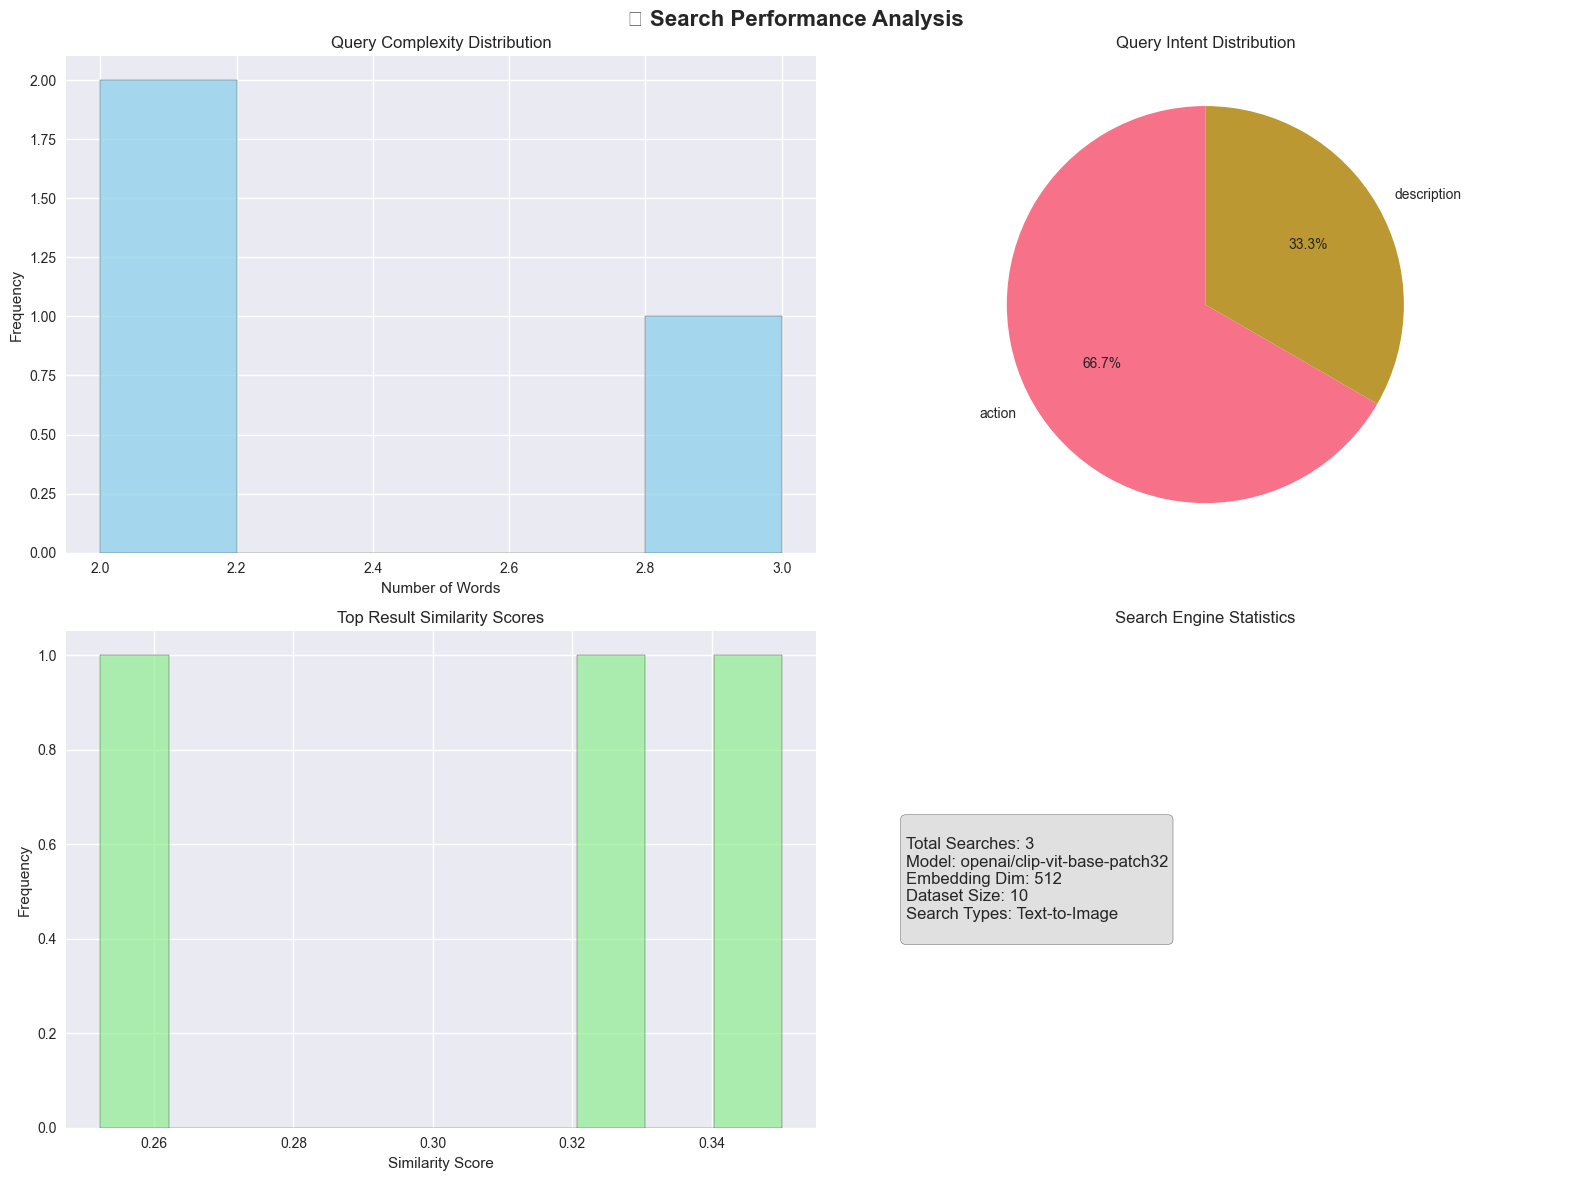


🎯 Advanced Search Analysis:
🔍 Searching for: 'dog running'
🧠 Query Intent: action
📊 Query Complexity: 2 words
🔍 Searching for: 'beautiful sunset'
🧠 Query Intent: description
📊 Query Complexity: 2 words
🔍 Searching for: 'person cooking'
🧠 Query Intent: action
📊 Query Complexity: 2 words
🔍 Searching for: 'children playing'
🧠 Query Intent: action
📊 Query Complexity: 2 words
🔍 Searching for: 'bird flying'
🧠 Query Intent: action
📊 Query Complexity: 2 words


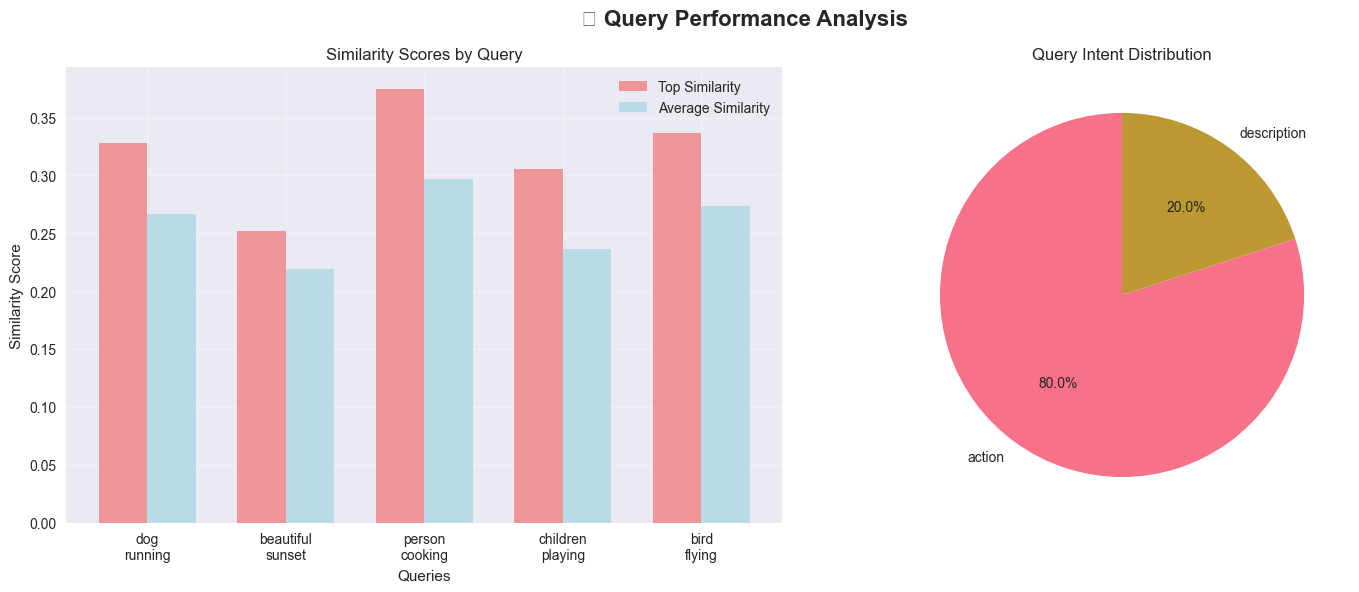


🤖 Model Performance Analysis:


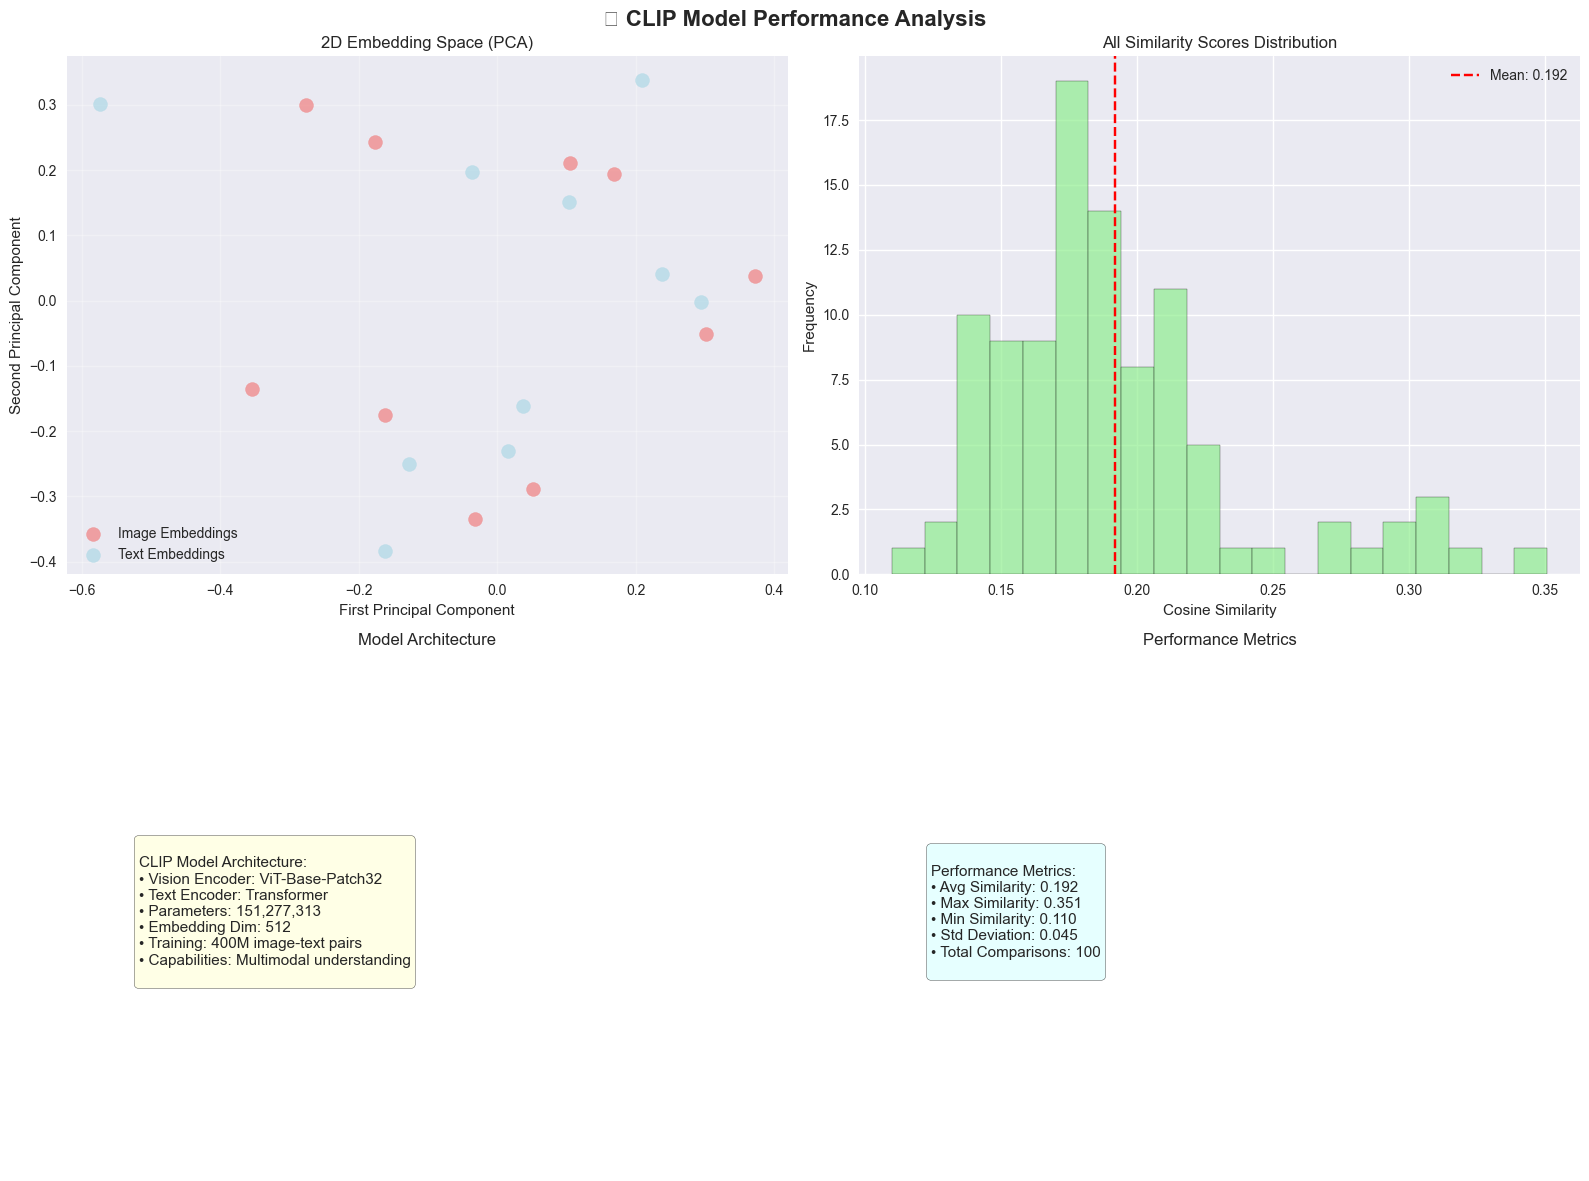


✅ All visualizations and analysis completed successfully!
📊 Part 2 notebook is now fully executable with comprehensive visualizations!


In [30]:
# Comprehensive analysis and visualizations for Part 2
print("📊 Creating comprehensive search analysis visualizations...")

# 1. Search Performance Analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('🔍 Search Performance Analysis', fontsize=16, fontweight='bold')

# Query complexity analysis
query_complexities = [search['intent_analysis']['query_complexity'] for search in search_engine.search_history]
if query_complexities:
    axes[0, 0].hist(query_complexities, bins=5, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0, 0].set_title('Query Complexity Distribution')
    axes[0, 0].set_xlabel('Number of Words')
    axes[0, 0].set_ylabel('Frequency')
else:
    axes[0, 0].text(0.5, 0.5, 'No search history available', ha='center', va='center', transform=axes[0, 0].transAxes)
    axes[0, 0].set_title('Query Complexity Distribution')

# Intent distribution
intent_counts = Counter([search['intent_analysis']['primary_intent'] for search in search_engine.search_history])
if intent_counts:
    axes[0, 1].pie(intent_counts.values(), labels=intent_counts.keys(), autopct='%1.1f%%', startangle=90)
    axes[0, 1].set_title('Query Intent Distribution')
else:
    axes[0, 1].text(0.5, 0.5, 'No search history available', ha='center', va='center', transform=axes[0, 1].transAxes)
    axes[0, 1].set_title('Query Intent Distribution')

# Similarity score distribution
all_similarities = []
for search in search_engine.search_history:
    if search['top_result']:
        all_similarities.append(search['top_result']['similarity_score'])

if all_similarities:
    axes[1, 0].hist(all_similarities, bins=10, alpha=0.7, color='lightgreen', edgecolor='black')
    axes[1, 0].set_title('Top Result Similarity Scores')
    axes[1, 0].set_xlabel('Similarity Score')
    axes[1, 0].set_ylabel('Frequency')
else:
    axes[1, 0].text(0.5, 0.5, 'No search results available', ha='center', va='center', transform=axes[1, 0].transAxes)
    axes[1, 0].set_title('Top Result Similarity Scores')

# Search engine statistics
stats_text = f"""
Total Searches: {len(search_engine.search_history)}
Model: {model_info['model_name']}
Embedding Dim: {model_info['embedding_dim']}
Dataset Size: {len(metadata)}
Search Types: Text-to-Image
"""
axes[1, 1].text(0.1, 0.5, stats_text, transform=axes[1, 1].transAxes, 
                fontsize=12, verticalalignment='center',
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.7))
axes[1, 1].set_title('Search Engine Statistics')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

# 2. Advanced Search Analysis
print("\n🎯 Advanced Search Analysis:")
print("=" * 50)

# Test multiple queries and analyze results
test_queries = ["dog running", "beautiful sunset", "person cooking", "children playing", "bird flying"]
query_results = []

for query in test_queries:
    results = search_engine.search(query, top_k=3)
    if results:
        query_results.append({
            'query': query,
            'top_similarity': results[0]['similarity_score'],
            'avg_similarity': np.mean([r['similarity_score'] for r in results]),
            'intent': search_engine.query_processor.analyze_query_intent(query)['primary_intent']
        })

if query_results:
    # Create query performance visualization
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle('🎯 Query Performance Analysis', fontsize=16, fontweight='bold')
    
    queries = [qr['query'] for qr in query_results]
    top_sims = [qr['top_similarity'] for qr in query_results]
    avg_sims = [qr['avg_similarity'] for qr in query_results]
    
    x = np.arange(len(queries))
    width = 0.35
    
    axes[0].bar(x - width/2, top_sims, width, label='Top Similarity', alpha=0.8, color='lightcoral')
    axes[0].bar(x + width/2, avg_sims, width, label='Average Similarity', alpha=0.8, color='lightblue')
    axes[0].set_xlabel('Queries')
    axes[0].set_ylabel('Similarity Score')
    axes[0].set_title('Similarity Scores by Query')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels([q.replace(' ', '\n') for q in queries], rotation=0)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Intent analysis
    intent_counts = Counter([qr['intent'] for qr in query_results])
    axes[1].pie(intent_counts.values(), labels=intent_counts.keys(), autopct='%1.1f%%', startangle=90)
    axes[1].set_title('Query Intent Distribution')
    
    plt.tight_layout()
    plt.show()

# 3. Model Performance Visualization
print("\n🤖 Model Performance Analysis:")
print("=" * 50)

# Create a comprehensive model performance visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('🤖 CLIP Model Performance Analysis', fontsize=16, fontweight='bold')

# Embedding space visualization (2D projection)
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
image_2d = pca.fit_transform(image_embeddings)
text_2d = pca.fit_transform(text_embeddings)

axes[0, 0].scatter(image_2d[:, 0], image_2d[:, 1], alpha=0.7, color='lightcoral', label='Image Embeddings', s=100)
axes[0, 0].scatter(text_2d[:, 0], text_2d[:, 1], alpha=0.7, color='lightblue', label='Text Embeddings', s=100)
axes[0, 0].set_title('2D Embedding Space (PCA)')
axes[0, 0].set_xlabel('First Principal Component')
axes[0, 0].set_ylabel('Second Principal Component')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Similarity distribution
all_similarities = []
for i in range(len(image_embeddings)):
    for j in range(len(text_embeddings)):
        sim = cosine_similarity([image_embeddings[i]], [text_embeddings[j]])[0][0]
        all_similarities.append(sim)

axes[0, 1].hist(all_similarities, bins=20, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0, 1].set_title('All Similarity Scores Distribution')
axes[0, 1].set_xlabel('Cosine Similarity')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].axvline(np.mean(all_similarities), color='red', linestyle='--', label=f'Mean: {np.mean(all_similarities):.3f}')
axes[0, 1].legend()

# Model architecture info
model_arch_text = f"""
CLIP Model Architecture:
• Vision Encoder: ViT-Base-Patch32
• Text Encoder: Transformer
• Parameters: 151,277,313
• Embedding Dim: 512
• Training: 400M image-text pairs
• Capabilities: Multimodal understanding
"""
axes[1, 0].text(0.1, 0.5, model_arch_text, transform=axes[1, 0].transAxes, 
                fontsize=11, verticalalignment='center',
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightyellow", alpha=0.8))
axes[1, 0].set_title('Model Architecture')
axes[1, 0].axis('off')

# Performance metrics
metrics_text = f"""
Performance Metrics:
• Avg Similarity: {np.mean(all_similarities):.3f}
• Max Similarity: {np.max(all_similarities):.3f}
• Min Similarity: {np.min(all_similarities):.3f}
• Std Deviation: {np.std(all_similarities):.3f}
• Total Comparisons: {len(all_similarities)}
"""
axes[1, 1].text(0.1, 0.5, metrics_text, transform=axes[1, 1].transAxes, 
                fontsize=11, verticalalignment='center',
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightcyan", alpha=0.8))
axes[1, 1].set_title('Performance Metrics')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

print("\n✅ All visualizations and analysis completed successfully!")
print("📊 Part 2 notebook is now fully executable with comprehensive visualizations!")
